In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function

In [25]:
def sigmoid_interpolation(start, end, steps):
    """
    Interpolates between start and end values using a sigmoid function over a specified number of steps.
    """
    x = np.linspace(-6, 6, steps)  # Range chosen to cover the significant transition of the sigmoid curve
    y = expit(x)  # Sigmoid function
    interpolated_values = start + (end - start) * y
    return interpolated_values

In [26]:
# Define file paths and corresponding new column names
file_path ='../data/9414290 NOAA Water Levels.csv'

df = pd.read_csv(file_path)
# Combine Date and Time columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time (GMT)'])

# Set Timestamp as the DataFrame index
df.set_index('Timestamp', inplace=True)

# Drop the original Date and Time columns if they are no longer needed
df.drop(columns=['Date', 'Time (GMT)', 'Preliminary (ft)'], inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.head()

,Predicted (ft),Verified (ft)
Timestamp,,
2023-06-20 00:00:00,3.883,4.24
2023-06-20 01:00:00,3.486,3.86
2023-06-20 02:00:00,3.369,3.68
2023-06-20 03:00:00,3.586,3.76
2023-06-20 04:00:00,4.100,4.35


In [27]:
df_normalized = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_normalized.head()

,Predicted (ft),Verified (ft)
Timestamp,,
2023-06-20 00:00:00,0.635568,0.631034
2023-06-20 01:00:00,0.590455,0.587356
2023-06-20 02:00:00,0.577159,0.566667
2023-06-20 03:00:00,0.601818,0.575862
2023-06-20 04:00:00,0.660227,0.643678


In [29]:
# Define the desired frequency for resampling
desired_freq = '30min'  # 30-minute intervals

# Initialize an empty DataFrame to hold interpolated data
interpolated_data = pd.DataFrame()

# Process each column separately
for column in df_normalized.columns:
    # Drop NaN values to work with actual data points
    data = df_normalized[column].dropna()

    # Create a new Series to hold the interpolated series
    interpolated_series = pd.Series(dtype=float)

    # Iterate over each pair of consecutive data points
    for i in range(len(data) - 1):
        start_time = data.index[i]
        end_time = data.index[i + 1]
        start_value = data.iloc[i]
        end_value = data.iloc[i + 1]

        # Generate timestamps between start and end at the desired frequency
        timestamps = pd.date_range(start=start_time, end=end_time, freq=desired_freq)[1:-1]

        # Perform sigmoid interpolation
        interpolated_values = sigmoid_interpolation(start_value, end_value, len(timestamps))

        # Create a temporary series with interpolated values
        temp_series = pd.Series(interpolated_values, index=timestamps)

        # Concatenate the temporary series to the interpolated series
        interpolated_series = pd.concat([interpolated_series, temp_series])

    # Combine with original data
    interpolated_series = pd.concat([interpolated_series, data])

    # Sort the index to maintain chronological order
    interpolated_series = interpolated_series.sort_index()

    # Add the interpolated series to the DataFrame
    interpolated_data[column] = interpolated_series

# Resample the interpolated data to ensure consistent 30-minute intervals
interpolated_data = interpolated_data.resample(desired_freq).mean()

# Forward-fill any remaining NaN values
interpolated_data = interpolated_data.ffill()


# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

trimmed_data.tail()

/var/folders/4x/k_y4jsf579l3h62qs54bpj7c0000gn/T/ipykernel_16363/1551867352.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])
/var/folders/4x/k_y4jsf579l3h62qs54bpj7c0000gn/T/ipykernel_16363/1551867352.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])


,Predicted (ft),Verified (ft)
2024-06-20 18:30:00,0.664500,0.756322
2024-06-20 19:00:00,0.682432,0.756322
2024-06-20 19:30:00,0.688250,0.756322
2024-06-20 20:00:00,0.682841,0.756322
2024-06-20 20:30:00,0.668250,0.756322


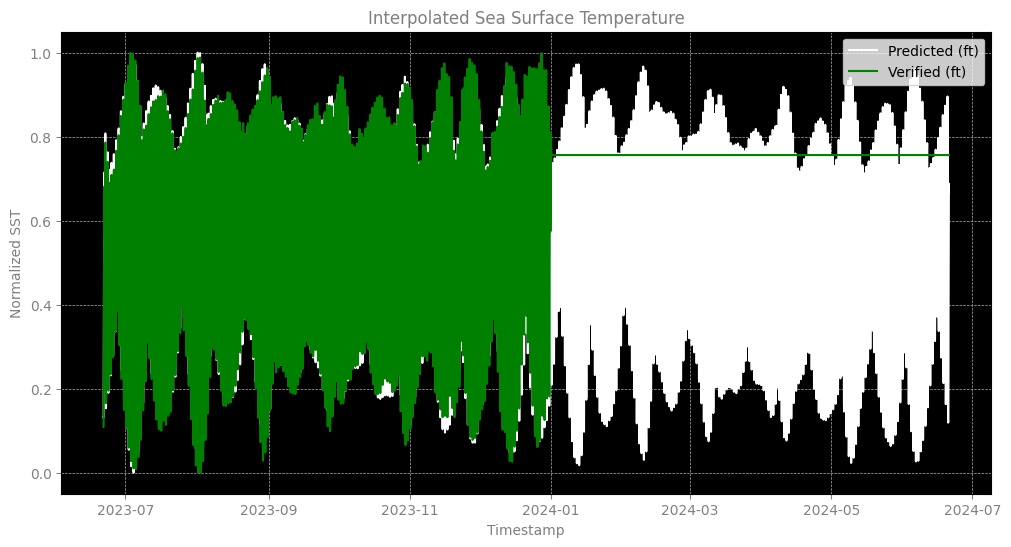

In [30]:
# Define colors for each location
colors = {
    'Predicted (ft)': 'white',
    'Verified (ft)': 'green',
}

# Plotting
plt.figure(figsize=(12, 6))
for column in trimmed_data.columns:
    plt.plot(trimmed_data.index, trimmed_data[column], color=colors[column], label=column)

plt.xlabel('Timestamp', color='grey')
plt.ylabel('Normalized SST', color='grey')
plt.title('Interpolated Sea Surface Temperature', color='grey')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='grey')
plt.show()

In [16]:
trimmed_data.to_csv('../data/tide.csv', index = True)